# Heart Disease UCI — Full ML Pipeline (Single Colab Notebook)
This notebook downloads the **Cleveland** heart disease dataset from UCI and runs a complete
ML pipeline: EDA → Preprocessing → PCA → Feature Selection → Supervised models → Unsupervised clustering →
Hyperparameter tuning → Model export → Streamlit app snippet. Run cells in order.

**Notes:**
- This notebook is designed to run in Google Colab (has internet). It will download the dataset automatically.
- If you run locally, ensure required packages are installed.


In [30]:

# Install required packages in Colab (uncomment if needed)
# !pip install -q scikit-learn pandas matplotlib seaborn joblib streamlit pyngrok scipy

import os, warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
import joblib
print('Setup complete.')


Setup complete.


In [31]:

# 1) Download dataset from UCI (Cleveland processed)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]
df = pd.read_csv(url, names=cols)
print('Loaded dataset shape:', df.shape)
df.head()


Loaded dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 2) Exploratory Data Analysis (EDA) — missing values, distributions, correlation heatmap

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal  

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


<Figure size 1200x800 with 0 Axes>

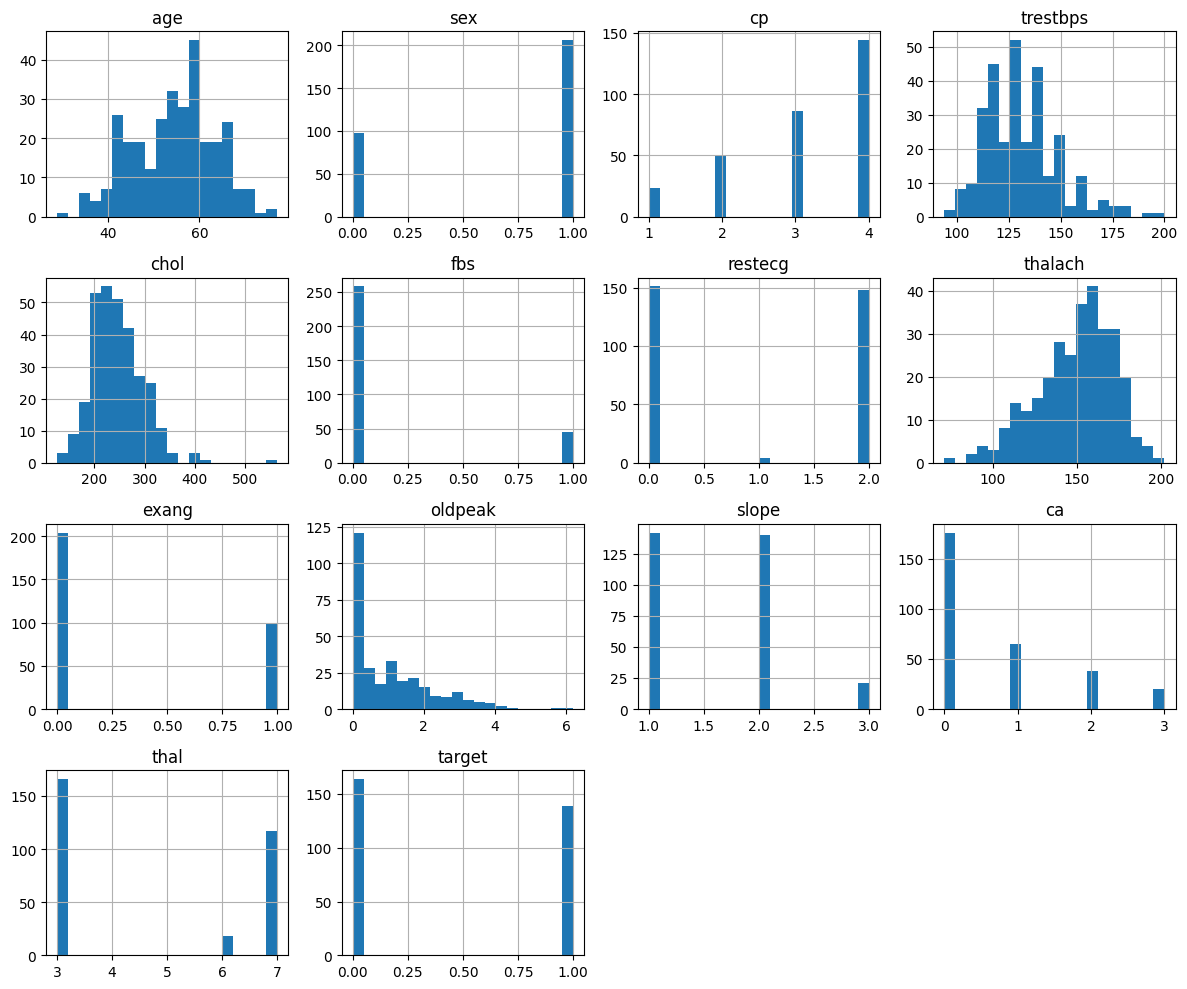

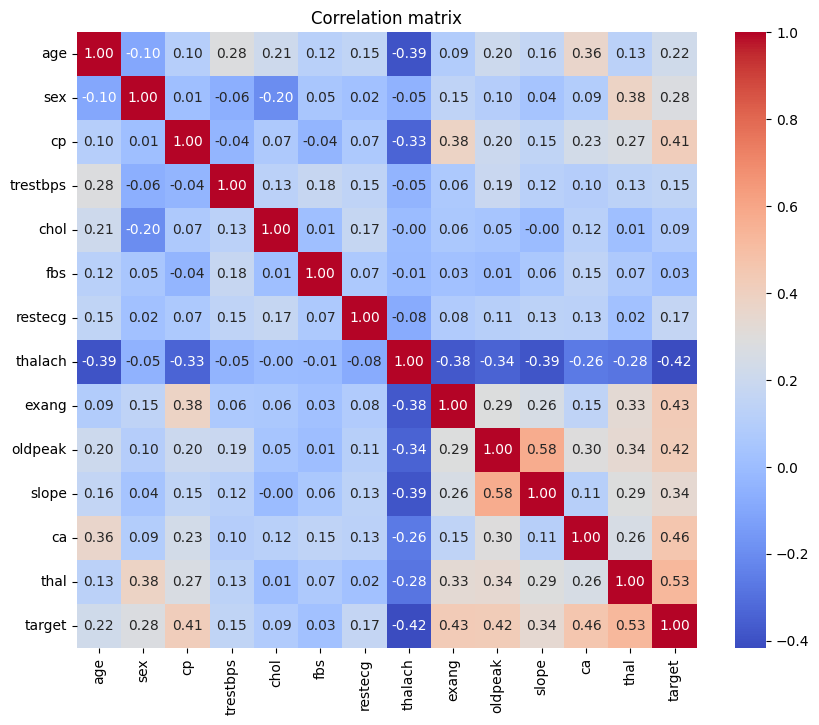

In [32]:

# Quick EDA
print(df.info()); print('\nMissing values per column:'); print(df.isnull().sum())

# Replace '?' with NaN and convert ca, thal
df.replace('?', np.nan, inplace=True)
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')
print('\nAfter converting ca & thal:')
print(df.isnull().sum())

# Target: convert to binary (0 = no disease, 1 = disease presence)
df['target'] = df['target'].apply(lambda x: 1 if x>0 else 0)

# Descriptive stats and plots
display(df.describe())

# Histograms
plt.figure(figsize=(12,8))
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


## 3) Preprocessing — imputation, one-hot encoding, scaling

In [33]:

# Impute numeric missing with median
for c in ['ca','thal']:
    if df[c].isnull().sum() > 0:
        df[c].fillna(df[c].median(), inplace=True)
print('Missing values after imputation:', df.isnull().sum().sum())

# One-hot encode categorical-ish columns: cp, restecg, slope, thal (thal is now numeric codes but treated as categorical)
cat_cols = ['cp','restecg','slope','thal']
df_proc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numeric columns (exclude target)
num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in num_cols:
    num_cols.remove('target')

scaler = StandardScaler()
df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])

print('Processed dataset shape:', df_proc.shape)
df_proc.head()


Missing values after imputation: 0
Processed dataset shape: (303, 19)


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,0.948726,0.686202,0.757525,-0.264900,2.394438,0.017197,-0.696631,1.087338,-0.711131,0,False,False,False,False,True,False,True,True,False
1,1.392002,0.686202,1.611220,0.760415,-0.417635,-1.821905,1.435481,0.397182,2.504881,1,False,False,True,False,True,True,False,False,False
2,1.392002,0.686202,-0.665300,-0.342283,-0.417635,-0.902354,1.435481,1.346147,1.432877,1,False,False,True,False,True,True,False,False,True
3,-1.932564,0.686202,-0.096170,0.063974,-0.417635,1.637359,-0.696631,2.122573,-0.711131,0,False,True,False,False,False,False,True,False,False
4,-1.489288,-1.457296,-0.096170,-0.825922,-0.417635,0.980537,-0.696631,0.310912,-0.711131,0,True,False,False,False,True,False,False,False,False


## 4) PCA — explained variance and projection

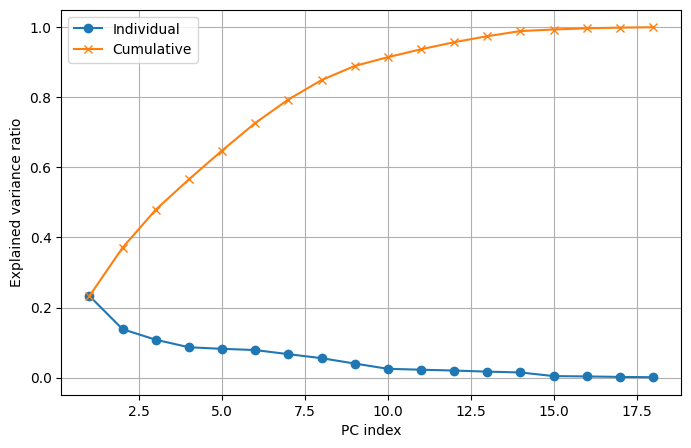

Components to retain ~95% variance: 12


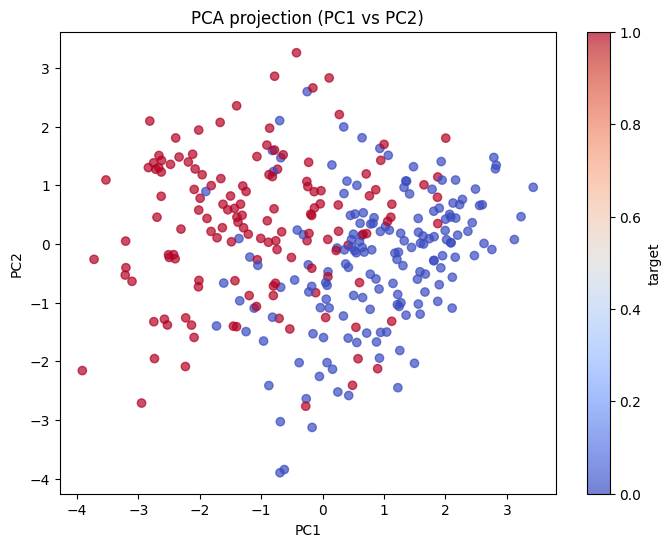

In [34]:

X = df_proc.drop(columns=['target'])
y = df_proc['target']

pca = PCA()
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker='o', label='Individual')
plt.plot(range(1, len(explained)+1), cum_explained, marker='x', label='Cumulative')
plt.xlabel('PC index'); plt.ylabel('Explained variance ratio'); plt.legend(); plt.grid(True); plt.show()

n_comp = int(np.argmax(cum_explained >= 0.95) + 1) if (cum_explained >= 0.95).any() else len(cum_explained)
print('Components to retain ~95% variance:', n_comp)

# Scatter of first two PCs colored by target
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA projection (PC1 vs PC2)'); plt.colorbar(label='target'); plt.show()


## 5) Feature Selection — RandomForest importances, RFE, Chi-square

Top 15 features by importance:


,0
thalach,0.128023
ca,0.115824
oldpeak,0.106851
thal_7.0,0.105555
cp_4.0,0.103977
age,0.090364
chol,0.074028
trestbps,0.072225
exang,0.057385
slope_2.0,0.033961


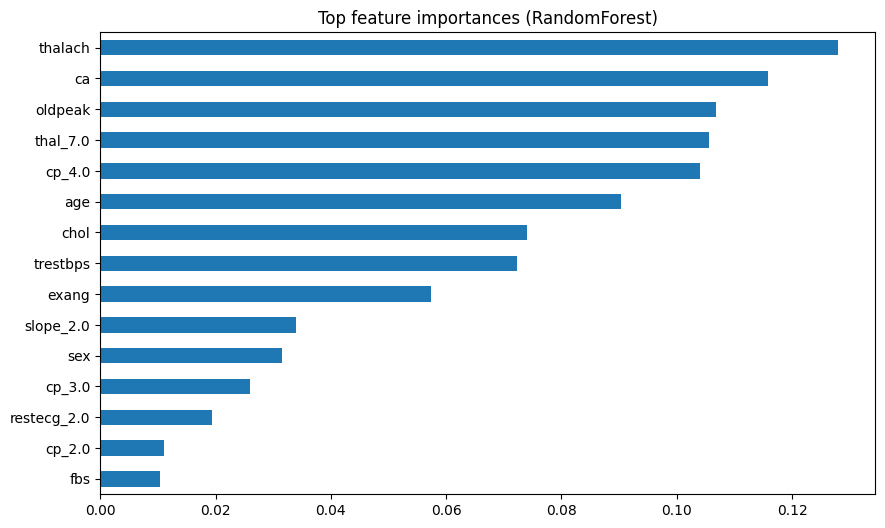

RFE selected features: ['sex', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_2.0', 'cp_4.0', 'restecg_2.0', 'slope_2.0', 'thal_7.0']
Chi2 top features: ['sex', 'exang', 'oldpeak', 'ca', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_2.0', 'slope_2.0', 'thal_7.0']
Final selected features (len=13):


['age',
 'ca',
 'chol',
 'cp_2.0',
 'cp_4.0',
 'exang',
 'oldpeak',
 'restecg_2.0',
 'sex',
 'slope_2.0',
 'thal_7.0',
 'thalach',
 'trestbps']

In [35]:

# RandomForest feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Top 15 features by importance:')
display(feat_imp.head(15))

plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top feature importances (RandomForest)')
plt.show()

# RFE with LogisticRegression to select up to 10 features
lr = LogisticRegression(max_iter=2000)
n_select = min(10, X.shape[1])
rfe = RFE(lr, n_features_to_select=n_select)
rfe.fit(X, y)
rfe_selected = X.columns[rfe.support_].tolist()
print('RFE selected features:', rfe_selected)

# Try Chi2 (requires non-negative) on absolute values as a check
try:
    skb = SelectKBest(score_func=chi2, k=min(10, X.shape[1]))
    skb.fit(np.abs(X), y)
    chi_selected = X.columns[skb.get_support()].tolist()
    print('Chi2 top features:', chi_selected)
except Exception as e:
    chi_selected = []
    print('Chi2 not applicable:', e)

# Final selected features (union of top importances & RFE)
selected_features = list(pd.Index(feat_imp.head(10).index).union(rfe_selected))
print('Final selected features (len={}):'.format(len(selected_features)))
display(selected_features)


## 6) Supervised Learning — train models, evaluate (accuracy, precision, recall, f1, AUC)


== LogisticRegression ==
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.81      0.89      0.85        28

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



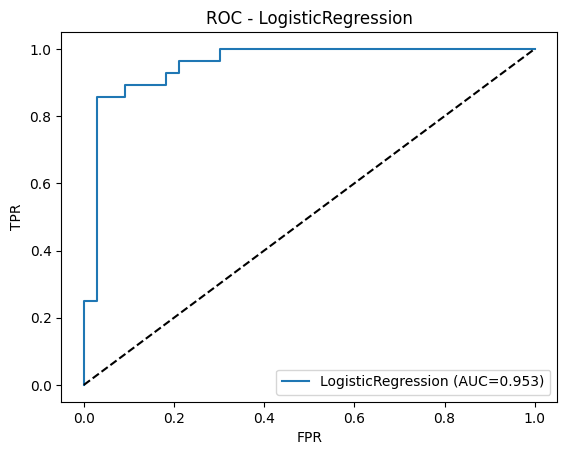


== DecisionTree ==
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        33
           1       0.74      0.93      0.83        28

    accuracy                           0.82        61
   macro avg       0.83      0.83      0.82        61
weighted avg       0.84      0.82      0.82        61



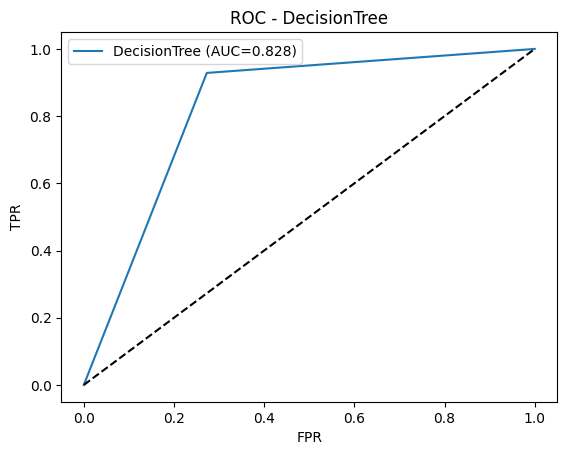


== RandomForest ==
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.90      0.96      0.93        28

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61



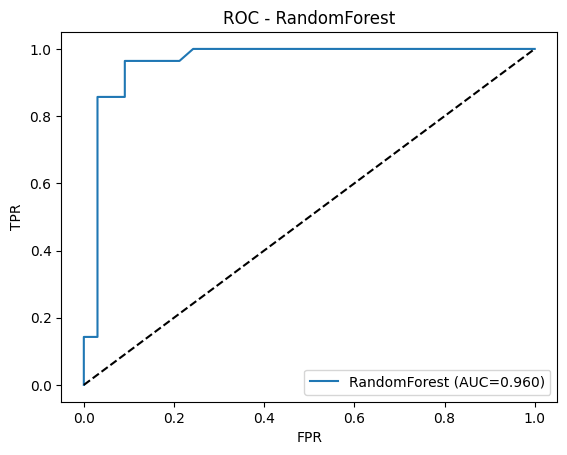


== SVM ==
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



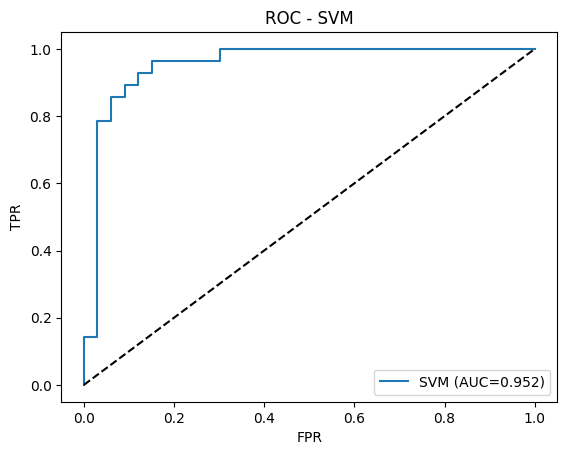


Summary:


,accuracy,precision,recall,f1,auc
LogisticRegression,0.852459,0.806452,0.892857,0.847458,0.953463
DecisionTree,0.819672,0.742857,0.928571,0.825397,0.827922
RandomForest,0.934426,0.900000,0.964286,0.931034,0.960498
SVM,0.901639,0.866667,0.928571,0.896552,0.952381


In [36]:

X_sel = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds),
        'auc': roc_auc_score(y_test, probs) if probs is not None else None
    }
    print('\n== {} =='.format(name))
    print(classification_report(y_test, preds))
    if probs is not None:
        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC={results[name]["auc"]:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {name}'); plt.legend(); plt.show()

print('\nSummary:')
display(pd.DataFrame(results).T)


## 7) Unsupervised Learning — KMeans elbow + Hierarchical dendrogram + cluster comparison

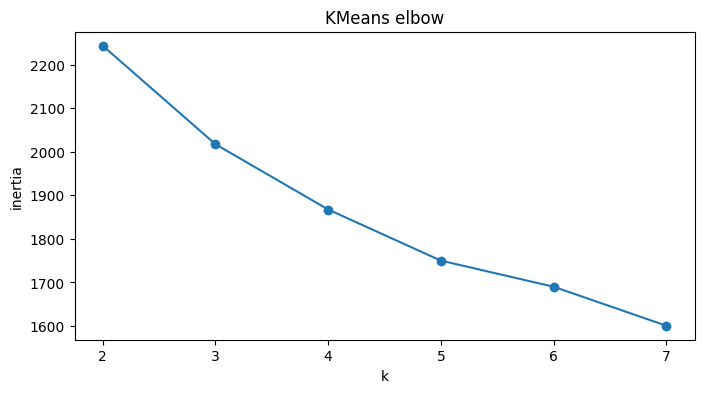

target,0,1
cluster,,
0,54,30
1,99,24
2,11,85


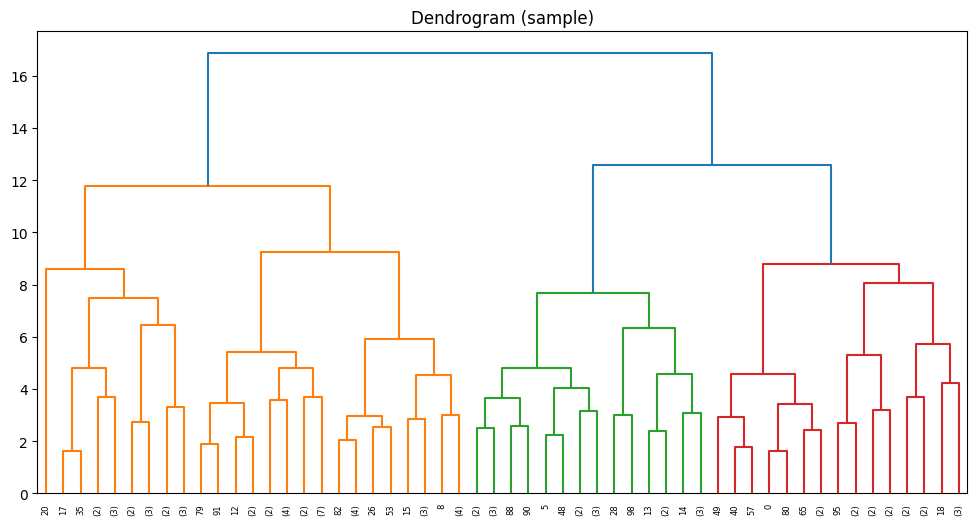

In [37]:

# KMeans elbow
inertia = []
K_range = range(2,8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_sel)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('k'); plt.ylabel('inertia'); plt.title('KMeans elbow'); plt.show()

# Fit KMeans with k=3 (example) and show cluster comparison
k_chosen = 3
km = KMeans(n_clusters=k_chosen, random_state=42)
clusters = km.fit_predict(X_sel)
ct = pd.crosstab(pd.Series(clusters, name='cluster'), y.reset_index(drop=True))
display(ct)

# Hierarchical dendrogram (sample for speed)
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    sample = X_sel.sample(min(100, X_sel.shape[0]), random_state=42)
    linked = linkage(sample, method='ward')
    plt.figure(figsize=(12,6))
    dendrogram(linked, truncate_mode='level', p=5)
    plt.title('Dendrogram (sample)'); plt.show()
except Exception as e:
    print('Dendrogram error (scipy may be missing):', e)


## 8) Hyperparameter Tuning — GridSearchCV example (RandomForest)

In [38]:

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,4]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params (RandomForest):', gs.best_params_)
best_rf = gs.best_estimator_
preds = best_rf.predict(X_test)
print('\nBest RF classification report:')
print(classification_report(y_test, preds))
if hasattr(best_rf, 'predict_proba'):
    print('AUC:', roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Best params (RandomForest): {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 200}

Best RF classification report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.90      0.96      0.93        28

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

AUC: 0.9621212121212122


## 9) Save final model bundle (scaler + features + model)

In [39]:

# Save the scaler, selected_features, and best model to a joblib file inside the notebook environment
os.makedirs('models', exist_ok=True)
model_bundle = {'scaler': scaler, 'selected_features': selected_features, 'model': best_rf}
joblib.dump(model_bundle, 'models/final_model.pkl')
print('Saved models/final_model.pkl')

Saved models/final_model.pkl


In [40]:
from google.colab import files
files.download("models/final_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10) Streamlit app code (written here so you can copy/paste into `app.py` or run on Colab)

In [41]:

# app_code = '''import streamlit as st
# import joblib
# import pandas as pd

# st.title("Heart Disease Risk Prediction")
# bundle = joblib.load("models/final_model.pkl")
# scaler = bundle['scaler']
# features = bundle['selected_features']
# model = bundle['model']

# st.write("Enter patient data:")
# inputs = {}
# for f in features:
#     inputs[f] = st.number_input(f, value=0.0)

# df_in = pd.DataFrame([inputs])
# try:
#     df_in_scaled = scaler.transform(df_in)
# except:
#     df_in_scaled = df_in.values

# pred = model.predict(df_in_scaled)
# prob = model.predict_proba(df_in_scaled)[:,1] if hasattr(model, 'predict_proba') else None
# st.write("Prediction (0=no disease, 1=disease):", int(pred[0]))
# if prob is not None:
#     st.write("Probability:", float(prob[0]))
# '''
# print('Streamlit app code is stored in the variable app_code. To save, run: open("ui/app.py","w").write(app_code)')

In [42]:

# # Save app.py file in the notebook environment for convenience
# os.makedirs('ui', exist_ok=True)
# with open('ui/app.py','w') as f:
#     f.write(app_code)
# print('Saved ui/app.py inside the notebook environment (you can download it alongside the notebook).')

## 11) Final notes
- Artifacts saved inside the notebook runtime: `models/final_model.pkl`, `ui/app.py`.
- To deploy: use Streamlit + ngrok (instructions in README_DEPLOY).

In [43]:

# Save a README with ngrok steps and requirements
readme = '''Deployment (quick)
1. pip install streamlit pyngrok
2. streamlit run ui/app.py
3. In another terminal: ngrok http 8501
4. Share ngrok URL
'''
with open('README_DEPLOY.md','w') as f:
    f.write(readme)
print('Saved README_DEPLOY.md')

requirements = '''pandas
numpy
scikit-learn
matplotlib
seaborn
joblib
streamlit
pyngrok
scipy
'''
with open('Heart_Disease_requirements.txt','w') as f:
    f.write(requirements)
print('Saved Heart_Disease_requirements.txt')


Saved README_DEPLOY.md
Saved Heart_Disease_requirements.txt
